<IPython.core.display.Javascript object>


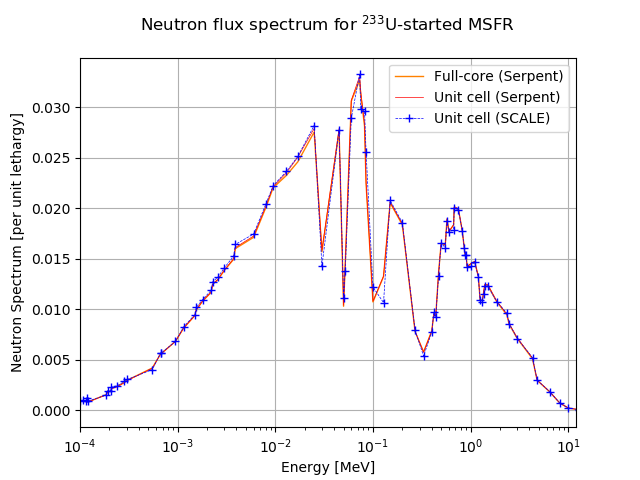

Correlation between neutron flux datasets (full-core and unit cell) is (0.9999860168197302, 0.0)
Average flux relative error 2.0643209364124004e-14 %
Full core, total flux (per unit volume) in fuel salt: 134.656; in fertile salt 7.2724
Cell core, total flux (per unit volume) in fuel salt: 134.49; in fertile salt 7.30553
Relative error in total flux, fuel salt 0.12327709125475048%
Relative error in total flux, fertile salt 0.4555580001100033%


Correlation between neutron flux datasets (Serpent-Full vs SCALE-Unit) is (0.9987733503311856, 4.72798329311157e-310)
Relative error in average flux (Serpent-Full vs SCALE-Unit) 0.0014551328487525175 %
Relative error in total calculated flux (Serpent-Full vs SCALE-Unit) 0.13516377933499427 %


In [12]:
%matplotlib notebook 
# Import modules
import numpy as np
import matplotlib.pyplot
from pyne import serpent
from pyne import nucname
from scipy.stats.stats import pearsonr 
import scipy.integrate as inte
from sklearn.metrics import mean_squared_error
from math import sqrt

det0 = serpent.parse_det('/home/andrei2/Desktop/ornl/msfr/serpent/full_core/msfr.inp_det0.m')
#det0 = serpent.parse_det('../serpent/core_det0.m')
#det0 = serpent.parse_det('../serpent/detector_plotting/both_900K/core_det0.m')
#det10 = serpent.parse_det('/home/andrei2/Desktop/ornl/msfr/serpent/unit_cell/msfr.inp_det0.m')
det10 = serpent.parse_det('/home/andrei2/Desktop/ornl/msfr/serpent/unit_cell/msfr.inp_det0.m')
#det10 = serpent.parse_det('/home/andrei2/Desktop/ornl/msfr/serpent/quarter/msfr.inp_det0.m')
#det10 = serpent.parse_det('../axial_reflector/core_det0.m')
energy_grid            = det0['DETspectrumE']
energy_grid_u            = det10['DETspectrumE']
spectrum_grid          = det0['DETspectrum']
spectrum_grid_u        = det10['DETspectrum']
full_total_flux_fuel   = det0['DETflux_fuel'][3][1]
full_total_flux_fert   = det0['DETflux_fertile'][3][1]
cell_total_flux_fuel   = det10['DETflux_fuel'][3][1]
cell_total_flux_fert   = det10['DETflux_fertile'][3][1]
# SCALE output 
filename = '../scale/sandbox/quarter_cell2.out'
start = "No    Energy(eV)   Flux       Flux      Adj.Flux   Adj.Flux"
stop  = "NOTE: Flux values above are per unit-lethargy."
#spectrum_grid_eq = det10['DETavrg']
#spectrum_grid_I = det0['DET1']
#spectrum_grid_II = det0['DET2']
#energy = energy_grid[:,2]
#flux_spectrum = spectrum_grid[:,10]
#print list(det0.keys())
#print np.amax(spectrum_grid[:,10])
#print np.sum(spectrum_grid[:,10])
#print np.trapz(spectrum_grid[:,10],energy)
#y = spectrum_grid[:,10]/np.trapz(spectrum_grid[:,10],energy)

def read_scale_out (filename):
    upp_enrg = []
    flux_list = []
    with open(filename,'r') as infile:
        copy = False
        for line in infile:
            if line.strip() == start:
                copy = True
            elif line.strip() == stop:
                copy = False
            elif copy:
                p = line.strip().split()
                if p != []:
                    upp_enrg.append(float(p[1]))  
                    flux_list.append(float(p[2]))                
    u_en = 1e-6* np.flip (np.array (upp_enrg, dtype=float), 0 )               # Convert eV to MeV
    flux = np.flip ( np.array (flux_list, dtype=float), 0 )
    num_gr = len (u_en)
    return u_en, flux, num_gr

ene_grid_sc, neutron_flux_sc, num_groups = read_scale_out (filename)

ene_grid_se = energy_grid[:,1]
neutron_flux_se = spectrum_grid[:,10]/np.sum(spectrum_grid[:,10])
neutron_flux_se_u = spectrum_grid_u[:,10]/np.sum(spectrum_grid_u[:,10])

#print np.trapz((np.trapz(y,energy)/np.trapz(spectrum_p,energy_p))*spectrum_p,energy_p)
#print np.trapz(spectrum_grid_I[:,10]/np.trapz(spectrum_grid_I[:,10],energy_grid[:,2]),energy_grid[:,2])
# Initialize figure
fig_1 = matplotlib.pyplot.figure(1)
ax = fig_1.add_subplot(111)
ax.grid(True)
#ax.set_ylim([0,15])
ax.set_xlim([1e-4,12])
ax.semilogx(ene_grid_se, neutron_flux_se, '-', label='Full-core (Serpent)', color='#ff8100', linewidth=1)
ax.semilogx(ene_grid_se, neutron_flux_se_u, '-', label='Unit cell (Serpent)', color='red', linewidth=0.5)
ax.semilogx(ene_grid_sc, neutron_flux_sc, '+--', label='Unit cell (SCALE)', color='blue', linewidth=0.5)
#ax.semilogx(ene_grid_sc, 100*abs(neutron_flux_sc - neutron_flux_se) / neutron_flux_sc ,
#            '-', label='Relative error', color='#ff8100', linewidth=0.5)
ax.set_title('Neutron flux spectrum for $^{233}$U-started MSFR\n')
ax.legend(loc=0)
ax.set_ylabel('Neutron Spectrum [per unit lethargy]')
#ax.set_ylabel('Relative error, %')
ax.set_xlabel('Energy [MeV]')
#ax.set_title(plot_title)
fig_1.show()
#fig_1.savefig('full_vs_unit_spectrum_238groups.png',bbox_inches='tight', dpi=900)
#fig_1.savefig('full_vs_unit_spectrum.png',bbox_inches='tight', dpi=700)
#fig_1.savefig('/home/andrei2/Desktop/git/pres/2018-rykh-seminar/images/spectrum.png',bbox_inches='tight', dpi=1000)

print ("Correlation between neutron flux datasets (full-core and unit cell) is "
           + str(pearsonr(neutron_flux_se,neutron_flux_se_u)  ) )

print ("Average flux relative error "+ str (100*abs((np.mean(neutron_flux_se_u)-np.mean(neutron_flux_se)))
                                            /np.mean(neutron_flux_se)) + ' %'  )

print ("Full core, total flux (per unit volume) in fuel salt: " + str (full_total_flux_fuel) +
       '; in fertile salt ' +str(full_total_flux_fert) )
print ("Cell core, total flux (per unit volume) in fuel salt: " + str (cell_total_flux_fuel) + 
       '; in fertile salt ' +str(cell_total_flux_fert) )
print ("Relative error in total flux, fuel salt " + str (100*abs (cell_total_flux_fuel-full_total_flux_fuel)  
            / full_total_flux_fuel) + '%')
print ("Relative error in total flux, fertile salt " + str (100*abs (cell_total_flux_fert-full_total_flux_fert)  
            / full_total_flux_fert) + '%')
print ('\n')
print ("Correlation between neutron flux datasets (Serpent-Full vs SCALE-Unit) is "
           + str(pearsonr(neutron_flux_se, neutron_flux_sc))  )

print ("Relative error in average flux (Serpent-Full vs SCALE-Unit) " + 
           str(100*abs(np.mean (neutron_flux_sc)-np.mean (neutron_flux_se)) / np.mean (neutron_flux_se))+' %')

print ("Relative error in total calculated flux (Serpent-Full vs SCALE-Unit) " + 
           str(100*abs(inte.simps (neutron_flux_sc,ene_grid_sc)-inte.simps (neutron_flux_se,ene_grid_se)) / 
               inte.simps (neutron_flux_se,ene_grid_se))+' %')